## Predict O2 output

Predict O2 output using different burner settings(for offline operation) and also using air and gas flow (for online operation). The initial predictions are made
depending on the burner settings but in operation the amount of O2 can vary how the gas and air flows are adjusted.

Import required packages:

In [58]:
import pandas as pd
import holoviews as hv
import hvplot.pandas
import data_processing_methods as dpm
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib import pyplot as plt
import plotly.express as px

Read the file with CV furnace burner settings

In [59]:
burner_settings_df = pd.read_excel('Burners_settings_vs_O2 _rev1.xlsx', sheet_name='Sheet1')
burner_settings_df

,Temperature setpoint / degC,Burners in use,Burner approx value,Burner turns from zero,Fan setpoint / %,Fan speed / RPM,Pressure setpoint / Pa,damper range / % (low),damper range / % (High),Output O2 / %,Output Burner usage / %
0,1100,2,0.0,0,80,2356,20,80,95,4.10,35.0
1,1100,2,0.0,0,65,1914,20,80,95,3.60,42.0
2,1100,2,1.0,2,65,1914,20,80,95,3.40,40.0
3,1100,2,3.0,5,65,1914,20,80,95,3.00,38.0
4,1100,2,3.0,5,50,1473,20,80,95,1.85,44.0
5,1100,2,3.0,5,50,1473,20,80,96,1.90,44.0
6,1100,2,4.5,7,50,1473,20,80,96,1.45,40.5
7,1100,2,6.0,9,50,1473,20,80,96,1.15,39.0
8,1100,2,6.0,9,45,1325,20,80,96,0.40,41.0
9,1100,2,6.0,9,47,1384,20,80,96,0.60,41.0


Plot differnt furnace settings

In [ ]:
burner_settings_df.hvplot()

Plot standardised furnace settings

In [ ]:
burner_settings_df = pd.read_excel('Burners_settings_vs_O2 _rev1.xlsx', sheet_name='Sheet1')
standardised_df = burner_settings_df.copy()
for col in burner_settings_df.columns:

    if (np.std(burner_settings_df[col])> 0):
        standardised_df[col] = dpm.standardise(burner_settings_df[col],np.mean(burner_settings_df[col]),np.std(burner_settings_df[col]))

    else:
        standardised_df = standardised_df.drop(columns=col)
    

standardised_df.hvplot(height= 500, width =1200, ylabel = 'Standardised furnace settings')

**Predict furnace O2 output**

After standardising furnace settings the correlation co-effcient of all the input parameters of the prediction model are evaluated so that similar type of data (corr coef. > 0.9) can be discarded.

In [62]:
# Find the correlation groups
X = standardised_df.drop(columns =['Output O2 / %', 'Output Burner usage / %'])
y = standardised_df['Output O2 / %']
corr_coef = X.corr(method='pearson')
corr_coef

,Temperature setpoint / degC,Burner approx value,Burner turns from zero,Fan setpoint / %,Fan speed / RPM,damper range / % (low),damper range / % (High)
Temperature setpoint / degC,1.000000,0.382453,0.412606,-0.462282,-0.462419,0.190476,-0.402309
Burner approx value,0.382453,1.000000,0.997648,-0.876333,-0.876370,0.286840,-0.225429
Burner turns from zero,0.412606,0.997648,1.000000,-0.890788,-0.890822,0.300893,-0.248008
Fan setpoint / %,-0.462282,-0.876333,-0.890788,1.000000,1.000000,-0.464713,0.207094
Fan speed / RPM,-0.462419,-0.876370,-0.890822,1.000000,1.000000,-0.464762,0.207250
damper range / % (low),0.190476,0.286840,0.300893,-0.464713,-0.464762,1.000000,-0.299392
damper range / % (High),-0.402309,-0.225429,-0.248008,0.207094,0.207250,-0.299392,1.000000


In [63]:
# Drop columns with corr coeffcients higher than 0.9 
X = X.drop(columns =['Burner turns from zero', 'Fan speed / RPM'])

In [113]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
#from sklearn.gaussian_process.kernels import Matern
#kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
# Train the ML model
X_train = X[10:]
y_train = y[10:]
gpr = GaussianProcessRegressor(kernel=kernel,
         random_state=0).fit(X_train, y_train)

X_predict = X
y_gpr_mean, y_gpr_std = gpr.predict(X_predict, return_std=True)

Plotting predicted and actual data

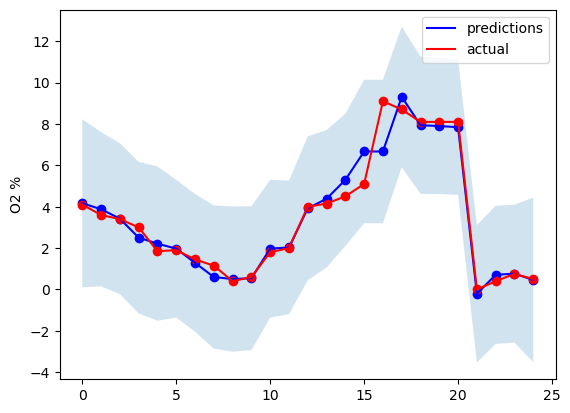

In [114]:

# plot predicted data
y_std = np.std(burner_settings_df['Output O2 / %'])
y_mean = np.mean(burner_settings_df['Output O2 / %'])
y_actual = y

plt.plot(y_gpr_mean*y_std+y_mean,'b',label='predictions')
plt.fill_between(range(len(y_actual)), (y_gpr_mean-3*y_gpr_std)*y_std+y_mean, (y_gpr_mean+3*y_gpr_std)*y_std+y_mean, alpha=0.2) 
plt.ylabel('O2 %')
plt.scatter(range(len(y_actual)),y_gpr_mean*y_std+y_mean,c='b')

plt.plot(range(len(y_actual)), y_actual*y_std+y_mean,'r',label='actual')
plt.scatter(range(len(y_actual)), y_actual*y_std+y_mean,c='r')
plt.legend()

Test the model for given valus of burner settings

In [8]:
# Predict O2 output for user defined input values
cols = list(X_train.columns)
X_new = pd.DataFrame([[int('1100'),int('-6'),int('80'),int('80'),int('96')]],
                         columns = cols)
X_new_pr= X_new.copy()
for col in cols:    
    X_new_pr[col] = dpm.standardise(X_new[col],np.mean(burner_settings_df[col]),np.std(burner_settings_df[col]))

y_new_predict = gpr.predict(X_new_pr)
Y_new = pd.DataFrame(y_new_predict*y_std+y_mean, columns=['Newly Predicted'])
Y_new

,Newly Predicted
0,7.100001


Generate random samples to simulate the developed ML model

In [9]:
# No. samples to be generated
N_samples = 1000
cols = list(X_train.columns)

# Initialise arrays to store samples of un-standardised and 
# standardised inputs
D = len (cols)
X_samples_us = np.zeros([N_samples, D])
X_samples = np.zeros([N_samples, D])

for i in range(N_samples):
    for j in range (D):
        X_samples_us[i, j] = np.random.uniform(np.min(burner_settings_df[cols[j]]), np.max(burner_settings_df[cols[j]]))

In [10]:
# Standardise the samples created
for j in range (D):    
    X_samples[:,j] = dpm.standardise(X_samples_us[:,j],np.mean(burner_settings_df[cols[j]]),np.std(burner_settings_df[cols[j]]))

# Save the predictions 
X_samples_df = pd.DataFrame(data = X_samples, columns = cols)
X_samples_us_df = pd.DataFrame(data = X_samples_us, columns = cols)
y_samples_predict = gpr.predict(X_samples_df)
y_samples_predict = y_samples_predict*y_std+y_mean
X_samples_us_df['Predicted O2 %'] = y_samples_predict

Plot predicted O2 output for generated random sample data and observe the general trend across the data distribution

In [11]:
# Find the mean of each bin (binning data)
n_bins = 30
x_plot = X_samples_us_df['Temperature setpoint / degC']
y_plot = X_samples_us_df['Predicted O2 %']

bins = np.linspace(np.min(x_plot), np.max(x_plot), n_bins)
main_effect = np.zeros(len(bins)-1)
main_effect_index = np.zeros(len(bins)-1)
main_effect_df = pd.DataFrame({})


for j in range(len(bins)-1):
    indx = np.logical_and(x_plot > bins[j], x_plot < bins[j+1])
    main_effect_index[j] = 0.5*(bins[j] + bins[j+1])

    # Only compute mean if there are any points in bin
    if np.sum(indx) > 0:
        main_effect[j] = np.mean(y_plot[indx])

main_effect_df['index'] = main_effect_index
main_effect_df['value'] = main_effect

In [ ]:
# plot main effects of model inputs
fig_a = X_samples_us_df.hvplot.scatter(x = 'Temperature setpoint / degC', y = 'Predicted O2 %', height = 500, width = 1000, hover_cols = 'all')
fig_b = main_effect_df.hvplot.line(x= 'index', y = 'value', xlim = [1100, 1150],color= 'red')
fig = fig_a*fig_b
fig

**Predict furnace O2 output using air and gas flow**

Sensor data realting to gas and air flow are filtered  before inputting to the prediction model. The data collected when the furnace is switched on are used for both model training and validation.

In [ ]:
# Read all air flow sensor data
df_merged = pd.read_pickle('merged_sensor_df.pkl')
df_merged = df_merged.resample('1T').mean()
cols = list(df_merged.columns[df_merged.columns.str.startswith('AIR_')])

df_air_merged_selected = df_merged.loc[:, df_merged.columns.str.startswith('AIR_')]
df_air_merged_filtered = df_air_merged_selected.copy()

for col in cols:
    df_air_merged_filtered.loc[:,col] = dpm.remove_spikes(df_air_merged_selected.loc[:,col],olr_def=1)
    df_air_merged_filtered.loc[:,col] = dpm.low_pass_filter(df_air_merged_filtered.loc[:,col],wn=0.1)
    
# Read gas flow sensor data    
df_merged = pd.read_pickle('merged_sensor_df.pkl')
df_merged = df_merged.resample('1T').mean()
cols = list(df_merged.columns[df_merged.columns.str.startswith('GAS_')])

df_gas_merged_selected = df_merged.loc[:, df_merged.columns.str.startswith('GAS_')]
df_gas_merged_filtered = df_gas_merged_selected.copy()

for col in cols:
    df_gas_merged_filtered.loc[:,col] = dpm.remove_spikes(df_gas_merged_selected.loc[:,col],olr_def=1)
    df_gas_merged_filtered.loc[:,col] = dpm.low_pass_filter(df_gas_merged_filtered.loc[:,col],wn=0.1)

    # Read gas flow sensor data    
df_merged = pd.read_pickle('merged_sensor_df.pkl')
df_merged = df_merged.resample('1T').mean()
cols = list(df_merged.columns[df_merged.columns.str.startswith('FURNACE_0126_341_04_O2')])

df_O2_selected = df_merged.loc[:, df_merged.columns.str.startswith('FURNACE_0126_341_04_O2')]
df_O2_filtered = df_O2_selected.copy()

for col in cols:
    df_O2_filtered.loc[:,col] = dpm.remove_spikes(df_O2_selected.loc[:,col],olr_def=1)
    df_O2_filtered.loc[:,col] = dpm.low_pass_filter(df_O2_filtered.loc[:,col],wn=0.01)

df_flow_combined = pd.concat([df_air_merged_filtered, df_gas_merged_filtered], axis=1)
df_flow_combined = pd.concat([df_flow_combined,df_O2_filtered], axis=1)
df_flow_combined = df_flow_combined[30000:-100]
df_flow_combined

In [14]:
# Standardise input data
standardised_df = df_flow_combined.copy()
for col in df_flow_combined.columns:

    if (np.std(df_flow_combined[col])> 0):
        standardised_df[col] = dpm.standardise(df_flow_combined[col],np.mean(df_flow_combined[col]),np.std(df_flow_combined[col]))
    else:
        standardised_df = standardised_df.drop(columns=col)

y = standardised_df['FURNACE_0126_341_04_O2']
X = standardised_df

Remove sensor data that closly correlate to exsisting data channels

In [15]:
corr_coef = df_air_merged_filtered.corr(method='pearson')
corr_coef

,AIR_0123_945_05_TE,AIR_PID_COMBUSTION_AIR_PV,AIR_PID_COMBUSTION_AIR_SP,AIR_PID_COMBUSTION_AIR_OUT,AIR_DRIVE_AIR_SPEED,AIR_0123_945_03_PT
AIR_0123_945_05_TE,1.000000,0.904505,-0.012509,-0.200774,0.860948,0.904539
AIR_PID_COMBUSTION_AIR_PV,0.904505,1.000000,-0.018975,-0.329993,0.980417,0.999999
AIR_PID_COMBUSTION_AIR_SP,-0.012509,-0.018975,1.000000,0.015881,-0.020769,-0.018973
AIR_PID_COMBUSTION_AIR_OUT,-0.200774,-0.329993,0.015881,1.000000,-0.503803,-0.330005
AIR_DRIVE_AIR_SPEED,0.860948,0.980417,-0.020769,-0.503803,1.000000,0.980417
AIR_0123_945_03_PT,0.904539,0.999999,-0.018973,-0.330005,0.980417,1.000000


In [16]:
corr_coef = df_gas_merged_filtered.corr(method='pearson')
corr_coef

,GAS_0110_943_07_FT_Nm3_h,GAS_0110_943_13_TE,GAS_0110_943_14_PT,GAS_0110_943_07_FT_m3_h
GAS_0110_943_07_FT_Nm3_h,1.000000,0.759686,0.904059,0.999954
GAS_0110_943_13_TE,0.759686,1.000000,0.894680,0.762845
GAS_0110_943_14_PT,0.904059,0.894680,1.000000,0.905818
GAS_0110_943_07_FT_m3_h,0.999954,0.762845,0.905818,1.000000


In [17]:
# Drop columns with corr coeffcients higher than 0.9 
X = X.drop(columns =['AIR_DRIVE_AIR_SPEED', 'AIR_0123_945_03_PT', 'GAS_0110_943_14_PT', 'GAS_0110_943_07_FT_m3_h'])

In [ ]:
fig_c = X.hvplot(height = 500, width = 1600, line_width = 2, grid= True)
fig_c 

**plot predicted and actual data**

First half of the data is used for model training while the rest of it is used for validation

In [19]:
# Select the datafor training
X_train = X[0:int(len(X)/2)]
y_train = y[0:int(len(X)/2)]

# Train Gaussian Process regression model
gpr = GaussianProcessRegressor().fit(X_train, y_train)
y_std = np.std(df_flow_combined['FURNACE_0126_341_04_O2'])
y_mean = np.mean(df_flow_combined['FURNACE_0126_341_04_O2'])

In [20]:
# Make predictions with model trained using gas and air flows
X_predict = X
y_predict = gpr.predict(X_predict)
y = y.reset_index()

In [ ]:
y_actual = y['FURNACE_0126_341_04_O2']
Y_df = pd.DataFrame(y_predict*y_std+y_mean, columns=['Predicted'])
Y_df['Actual'] = y_actual*y_std+y_mean 
Y_df['Date'] = y['Date']
Y_df.set_index('Date',inplace=True)
Y_df = Y_df[int(len(X)/2):]
fig_a = px.line(Y_df, labels={
                     "value": "O2 output",
                 }, title='O2 predictions - (w.r.t gas and air flows)',height=600, width=920)
fig_a 